<a href="https://colab.research.google.com/github/mehdi-or/203B/blob/master/Metadata_making_fMRI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import DataFrame
import csv

mounting the Gdrive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=False)

Mounted at /content/gdrive


This function is written to load the data

In [ ]:
def load_data(subject, dim=20):
    #accuracy = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/fMRI/VT/AE_plain/s' + str(subject)+ '/accuVsdim.csv', header=None ).values
    #X_test = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/fMRI/VT/AE_plain/s' + str(subject)+ '/X_test_'+str(dim)+'.csv', header=None ).values
    #decoded_VT = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/fMRI/VT/AE_plain/s' + str(subject)+ '/decoded_VT_'+str(dim)+'.csv', header=None ).values
    #BN = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/fMRI/VT/AE_plain/s' + str(subject)+ '/decoded_VT_'+str(dim)+'.csv', header=None ).values

    accuracy = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/dim_reduc_project/AE_plus/fMRI/s' + str(subject)+ '/accuVsdim.csv', header=None ).values
    X_test = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/dim_reduc_project/AE_plus/fMRI/s' + str(subject)+ '/X_test_'+str(dim)+'.csv', header=None ).values
    decoded_VT = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/dim_reduc_project/AE_plus/fMRI/s' + str(subject)+ '/decoded_VT_'+str(dim)+'.csv', header=None ).values
    BN = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/dim_reduc_project/AE_plus/fMRI/s' + str(subject)+ '/BN_dim_'+str(dim)+'.csv', header=None ).values

    return(accuracy, X_test, decoded_VT, BN)

This function is written to find the mean correllation of the digonal of 40x40 classes similarity matrix

In [ ]:
def class_diagonal(categ_aranged, corr, num_trials, test_label):

  diag_index = range(num_trials) # to find the index of the diagonals of the test-set matrix
  corr_zero = np.copy(corr)
  corr_zero[diag_index, diag_index]=0 # to remove the auto-correlaiton of the trials
  corr_df = pd.DataFrame(corr_zero) # turning it to DataFrame to make my life easier by ALOT
  corr_df.columns=test_label # to name the columns of the correlation
  corr_df.index = test_label # to name the rows of the correlation
  unique_class = np.unique(test_label) # to find what uniqw classes we have in the test-set
  class_matrix_corr = np.zeros((len(unique_class),len(unique_class))) # this is the correlation of the mean values of the classes
  #trial_matrix_corr = np.zeros(corr.shape) # this is the correlation of every trials based on the arranged categories
  #trial_matrix_corr =np.zeros(corr.shape) # this is the correlation of every trials based on the arranged categories

  for i, row in enumerate(categ_aranged):
    for j, column in enumerate(categ_aranged):
      #trial_matrix_corr [row, column]=  corr_df.loc[row][column]
      if i==j:
        n_examples = np.sqrt(corr_df.loc[row][column].size) # this is for the case of autocorrelation that we have already put zeros for them so it is fair to not consider them while getting the mean
        #print( row + ' = ' + str(n_examples) + ' trials')
        class_matrix_corr [i,j] = corr_df.loc[row][column].sum().sum()/(n_examples**2 - n_examples)
      else:
        class_matrix_corr [i,j]= corr_df.loc[row][column].mean().mean()
  return(class_matrix_corr)

To calulate pairwise Eculidean distance

In [ ]:
def EDM(A,B):
  p1=np.sum(A**2, axis=1)[:, np.newaxis]
  p2=np.sum(B**2, axis=1)
  p3=-2*np.dot(A,B.T)
  return np.round(np.sqrt(p1+p2+p3), 2)

This is to write the

In [ ]:
networks = ['AE_plain', 'AE_plus'] # which network arichitecture we want to use
subjects = range(37,47) # subjects we are looking at
label = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/CNC data/label.csv').values # reading the labels based on the order showing to the subjects
categ_aranged = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/CNC data/unique_aranged.csv', header=None).iloc[:,1].values # these are 40 classes that are arranged based on categories
#the map for all subject is the same so any one would be fine for it. I am using subjects[0]
#map = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/fMRI/VT/AE_plain/s' + str(subjects[0])+ '/map2.csv', header=None ).values.astype(int) 
map = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/dim_reduc_project/AE_plus/fMRI/s' + str(subjects[0])+ '/map2.csv', header=None ).values.astype(int) 
test_label = label[map] # finding which exaplars were used in the test-set while training the AE/AE+
test_label= test_label.reshape(test_label.shape[0])
num_trials = map.shape[0]
accuracy_dictionary ={} #creating bunch of dictionaries to store data
corr_dictionary = {}
corr_class_dictionary = {}

corr_BN_class_dictionary = {}
corr_BN_class_dictionary_new = {}
dims = [1500, 1000, 500, 250, 200, 150, 100, 60, 50, 30, 20, 15, 10, 5, 2] # mdimension of the BottleNeck
for subject in subjects:
  [accuracy,_,_,_] = load_data(subject)
  corr_list = [] # a list of correlaion of the decoded examplars vs actual imput for subject i (900x900)
  corr_class_list = [] # a list of correlation of the categoreies for VT and decoded (40x40)
  corr_BN_class_list = [] # a list of correlation of the categoreies for BN(40x40)
  corr_BN_class_list_new = [] # a list of correlation of the categoreies for BN(40x40) based on "to calculate the "diag_corr-off_diag_corr"
  for dim in dims:
        [_,X_test,decoded_VT, BN] = load_data(subject, dim)
        corr = np.corrcoef(X_test, decoded_VT) # correlation of input and decoded VT
        indx = int(corr.shape[0]/2) 
        corr=corr[indx:,:indx] # we want only the part of the correlation matrix between the X_test and decoded_VT
        diagonal_corr_mean= np.diagonal(corr).mean()
        corr_list.append(diagonal_corr_mean) # listing the mean of the diagonal of correlation for each dimension
        
        class_matrix_corr = class_diagonal(categ_aranged, corr, num_trials, test_label)
        diagonal_class_corr_mean = np.diagonal(class_matrix_corr).mean()
        corr_class_list.append(diagonal_class_corr_mean) # the mean correlation of the the diagonal based on the categories (not examplars) for VT input to decoded VT output

        corr_BN = np.corrcoef(BN) 
        class_matrix_corr_BN = class_diagonal(categ_aranged, corr_BN, num_trials, test_label)
        diagonal_class_corr_BN_mean = np.diagonal(class_matrix_corr_BN).mean() # the mean of diagonal
        corr_BN_class_list.append(diagonal_class_corr_BN_mean) # the mean correlation of the the diagonal based on the categories (not examplars) for BN
        #to calculate the "diag_corr/off_diag_corr"
        off_diag = np.where(~np.eye(class_matrix_corr_BN.shape[0],dtype=bool))
        diagonal_matrix_corr_off_diag_mean = class_matrix_corr_BN[off_diag].mean()
        #diagonal_matrix_corr_off_diag_mean = class_matrix_corr_off_diag.mean().mean()
        diagonal_class_corr_BN_mean_new = diagonal_class_corr_BN_mean - diagonal_matrix_corr_off_diag_mean
        corr_BN_class_list_new.append(diagonal_class_corr_BN_mean_new)


        if subject==subjects[-1]:
          fig, (ax1, ax2) = plt.subplots(1,2)
          ax1.imshow(class_matrix_corr, vmin = 0, vmax =0.9)
          ax2.imshow(class_matrix_corr_BN, vmin = 0, vmax =0.9)
          fig.suptitle('BN_dim= '+ str(dim))
          ax1.set_title('for VT2VT')
          ax2.set_title('for BN')

  corr_dictionary['subject%s' %subject] = corr_list
  corr_class_dictionary['subject%s' %subject] = corr_class_list

  accuracy_dictionary['subject%s' %subject] = accuracy

  corr_BN_class_dictionary['subject%s' %subject] = corr_BN_class_list
  corr_BN_class_dictionary_new ['subject%s' %subject] = corr_BN_class_list_new




Wrtting the dictionary files into a csv

(0.0, 1.2)

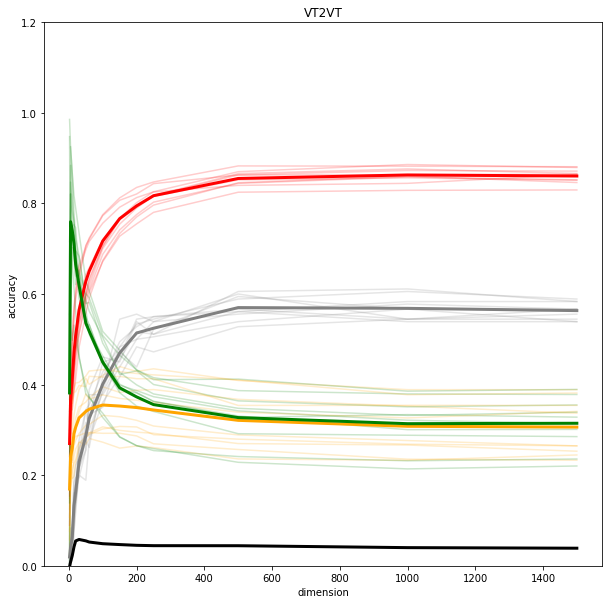

In [ ]:
index_name = ['1500', '1000', '500', '250', '200', '150', '100', '60', '50', '30', '20', '15', '10', '5', '2']
col_name =['dimension','accuracy', 'corr','corr_class', 'corr_BN_class']
dim1= accuracy.shape[0] # number of the diffrent dimesion of BN (here is 15)
dim2= len(subjects) # number of the subjects (here is 10)
accuracy_all = np.zeros((dim1, dim2)) #storing all accuracy comprasing of (dim1*dim2 elements)

corr_all = np.zeros((dim1, dim2))
corr_class_all = np.zeros((dim1, dim2))

corr_BN_all = np.zeros((dim1, dim2))
corr_BN_class_all = np.zeros((dim1, dim2))
corr_BN_class_all_new = np.zeros((dim1, dim2))

plt.figure(figsize=(10,10))
AE_plain_fmri = np.zeros((dim1, 5, dim2))
for i, subject in enumerate(subjects):
    accuracy = accuracy_dictionary['subject'+str(subject)]

    corr_list = corr_dictionary['subject'+str(subject)]
    corr_class_list = corr_class_dictionary['subject'+str(subject)]

    corr_BN_class_list = corr_BN_class_dictionary['subject'+str(subject)]
    corr_BN_class_list_new = corr_BN_class_dictionary_new['subject'+str(subject)]

    accuracy_all[:,i] = accuracy[:,1]

    corr_all[:,i] = corr_list
    corr_class_all[:,i] = corr_class_list

    corr_BN_class_all[:,i] = corr_BN_class_list
    corr_BN_class_all_new[:,i] = corr_BN_class_list_new

    plt.plot(accuracy[:,0], accuracy[:,1], alpha=0.2, c= 'grey')

    plt.plot(accuracy[:,0], corr_list, alpha=0.2, c='red')
    plt.plot(accuracy[:,0], corr_class_list, alpha=0.2, c='orange')

    plt.plot(accuracy[:,0], corr_BN_class_list, alpha=0.2, c='green')

    AE_plain_fmri[:,:,i] = np.asarray([accuracy[:,0], accuracy[:,1], corr_list, corr_class_list, corr_BN_class_list_new]).T
    DataFrame(AE_plain_fmri[:,:,i],index=index_name, columns=col_name).to_csv('/content/gdrive/MyDrive/Colab Notebooks/dim_reduc_project/AE_plus/plus_meta_data/s_'+str(subject)+'_metadata.csv')

    #plt.xlim([0,30])


accuracy1 = np.asarray(accuracy)
mean_accuracy = np.mean(accuracy_all, axis=1)
mean_corr = np.mean(corr_all, axis=1)
mean_corr_class = np.mean(corr_class_all, axis=1)
mean_corr_BN = np.mean(corr_BN_all, axis=1)
mean_corr_BN_class = np.mean(corr_BN_class_all, axis=1)
mean_corr_BN_class_new = np.mean(corr_BN_class_all_new, axis=1)


plt.plot(accuracy[:,0],mean_accuracy, linewidth=3, c='grey')
plt.plot(accuracy[:,0],mean_corr, linewidth=3, c = 'red')
plt.plot(accuracy[:,0],mean_corr_class, linewidth=3, c = 'orange')
plt.plot(accuracy[:,0],mean_corr_BN_class, linewidth=3, c = 'green')
plt.plot(accuracy[:,0],mean_corr_BN_class_new, linewidth=3, c = 'black')
plt.title('VT2VT')
plt.xlabel('dimension')
plt.ylabel('accuracy')
plt.ylim([0,1.2])
#plt.xlim([0,200])


In [ ]:
normalized = (mean_corr_BN_class_new-np.min(mean_corr_BN_class_new))/(np.max(mean_corr_BN_class_new)-np.min(mean_corr_BN_class_new))

fig,ax = plt.subplots()
ax.plot(accuracy[:,0],mean_accuracy, linewidth=3, c='grey')
ax.plot(accuracy[:,0],mean_corr, linewidth=3, c = 'red')
ax.plot(accuracy[:,0],mean_corr_class, linewidth=3, c = 'orange')
ax.plot(accuracy[:,0],mean_corr_BN_class, linewidth=3, c = 'green')

ax.set_title('VT2VT')
ax.set_xlabel('dimension')
ax.set_ylabel('accuracy')
ax2 = ax.twinx()
ax2.set_ylabel('corr_ratio', c='black')
ax2.plot(accuracy[:,0],normalized, linewidth=3, c = 'black')
plt.ylim([0,1])
#plt.xlim([0,200])

(0.0, 250.0)

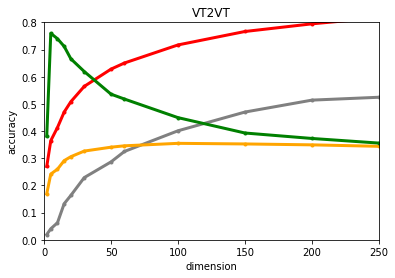

In [ ]:
plt.plot(accuracy[:,0],mean_accuracy,'.-', linewidth=3, c='grey')
plt.plot(accuracy[:,0],mean_corr, '.-', linewidth=3, c = 'red')
plt.plot(accuracy[:,0],mean_corr_class, '.-', linewidth=3, c = 'orange')
plt.plot(accuracy[:,0],mean_corr_BN_class, '.-', linewidth=3, c = 'green')
plt.title('VT2VT')
plt.xlabel('dimension')
plt.ylabel('accuracy')
plt.ylim([0,0.8])
plt.xlim([0,250])